<a href="https://colab.research.google.com/github/greyhound101/Brain_tumour/blob/master/embedding_difference_512_e2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [2]:
pip install pydicom

In [3]:
pip install tensorflow==2.2.0

In [4]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [5]:


def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)
ROOT = "/content/gdrive/My Drive/lungs"
BATCH_SIZE=128
a = pd.read_csv(f"{ROOT}/sample_submission.csv")
a['Patient']=a['Patient_Week'].apply(lambda x:x.split('_')[0])
tr = pd.read_csv(f"{ROOT}/train.csv")

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")


sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
total = tr.append([chunk, sub])

print(tr.shape, chunk.shape, sub.shape, total.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      total.Patient.nunique())



(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:


from tqdm import tqdm
i=0
for patient,sudo in tqdm(total.groupby(['Patient'])):
    for limit in sudo['Weeks'].unique():
        data=sudo.loc[sudo['Weeks']>=limit]
        data['difference']=data['Weeks']-limit
        data['min_week'] = data['Weeks']
        data.loc[data.WHERE=='test','min_week'] = np.nan
        data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
        base = data.loc[data.Weeks == data.min_week]
        base = base[['Patient','FVC']].copy()
        base.columns = ['Patient','min_FVC']
        base['nb'] = 1
        base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
        base = base[base.nb==1]
        base.drop('nb', axis=1, inplace=True)
        data = data.merge(base, on='Patient', how='left')
        data['base_week'] = data['Weeks'] - data['min_week']
        COLS = ['Sex','SmokingStatus'] #,'Age'
        FE = []
        data['age'] = (data['Age'] - data['Age'].min() ) 
        data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) 
        data['week'] = (data['base_week'] - data['base_week'].min() ) 
        data['percent'] = (data['Percent'] - data['Percent'].min() ) 
        FE += ['age','percent','week','BASE']
        if sum(data[FE].isna().sum().values) >0 and not all(data['WHERE']=='test'):
            print(limit,patient,data[FE].isna().sum().values)
        i+=1
        if i==1:
            augmented=data
        else:
            augmented=pd.concat([augmented,data],0)



100%|██████████| 176/176 [01:03<00:00,  2.77it/s]


In [8]:
augmented['i']=list(range(augmented.shape[0]))

In [9]:
FE=['Male','Female','Ex-smoker','Never smoked','Currently smokes']
FE += ['age','percent','week','BASE']

In [10]:
for col in COLS:
    for mod in augmented[col].unique():
        FE.append(mod)
        augmented[mod] = (augmented[col] == mod).astype(int)

In [11]:
augmented['Patient_Week']=augmented['Patient'].astype(str)+'_'+augmented['Weeks'].astype(str)

In [12]:
sub1 = augmented.loc[augmented.WHERE=='test']

In [13]:
augmented['age'] = (augmented['Age']  ) / ( augmented['Age'].max() - augmented['Age'].min() )
augmented['BASE'] = (augmented['min_FVC']  ) / ( augmented['min_FVC'].max() - augmented['min_FVC'].min() )
augmented['week'] = (augmented['base_week']  ) / ( augmented['base_week'].max() - augmented['base_week'].min() )
augmented['difference'] = (augmented['difference']  ) / ( augmented['difference'].max() - augmented['difference'].min() )
augmented['percent'] = (augmented['Percent']  ) / ( augmented['Percent'].max() - augmented['Percent'].min() )

In [14]:


tr = augmented.loc[augmented.WHERE=='train']
chunk = augmented.loc[augmented.WHERE=='val']
sub = augmented.loc[augmented.WHERE=='test']



In [15]:
for en,(i,data) in tqdm(enumerate(sub1.groupby(['Patient_Week']))):
    sm=sum(data['difference'])
    data['difference']=data['difference']/sm
    data=data.sort_values(by='difference')
    data['difference']=data['difference'].values[::-1]
    if en==0:
        total=data
    else:
        total=pd.concat([total,data],0)

730it [00:13, 56.07it/s]


In [16]:
import gc
del sub1
gc.collect()

0

In [17]:
tr.shape, chunk.shape, sub.shape

((8928, 24), (109, 24), (53655, 24))

In [18]:


print(sub.shape)
print(total.shape)
sub=sub.dropna(subset=FE)
total=total.dropna(subset=['week','BASE'])
print(sub.shape)
print(total.shape)



(53655, 24)
(53655, 24)
(39188, 24)
(39188, 24)


In [19]:
sub['difference'].nunique()

146

In [20]:

from tensorflow.keras.regularizers import *
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    emb = L.Input((1,))
    emb1 = L.Embedding(input_dim=147,output_dim=512,embeddings_regularizer=l2(1e-2))(emb)
    c = L.Concatenate()([z,L.Flatten()(emb1)])
    x = L.Dense(100, activation="relu", name="d1")(c)
    x = L.Dropout(0.2)(x)
    x = L.Dense(100, activation="relu", name="d2")(x)
    x = L.Dropout(0.2)(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model([z,emb], preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 512)       75264       input_1[0][0]                    
__________________________________________________________________________________________________
Patient (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 512)          0           embedding[0][0]                  
________________________________________________________________________________________________

In [21]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)

In [22]:
tr[FE].head()

,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,percent,week,BASE,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,1,0,1,0,0,2.025641,0.468775,0.000000,0.41547,1,0,1,0,0
1,1,0,1,0,0,2.025641,0.448323,0.055556,0.41547,1,0,1,0,0
2,1,0,1,0,0,2.025641,0.417341,0.067901,0.41547,1,0,1,0,0
3,1,0,1,0,0,2.025641,0.434148,0.080247,0.41547,1,0,1,0,0
4,1,0,1,0,0,2.025641,0.418961,0.092593,0.41547,1,0,1,0,0


In [23]:
tr=tr.reset_index(drop=True)

FOLD 1


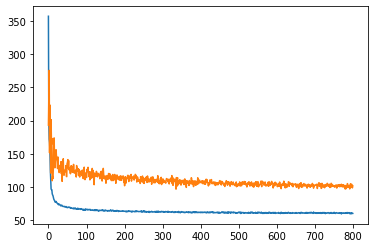

predict val...
predict test...
FOLD 2


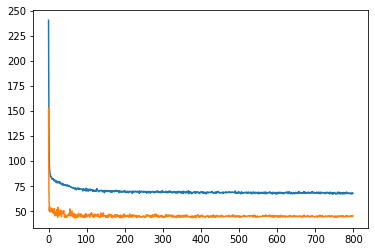

predict val...
predict test...
FOLD 3


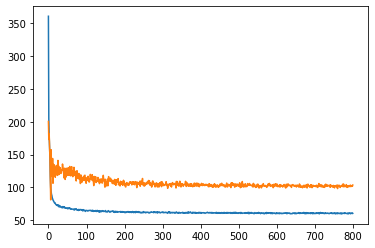

predict val...
predict test...
FOLD 4


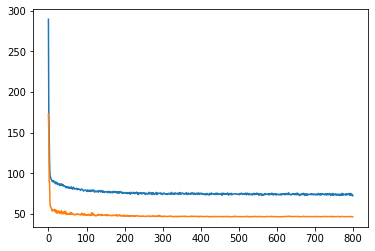

predict val...
predict test...
FOLD 5


In [ ]:

cnt = 0
EPOCHS = 800
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    hist=net.fit([z[tr_idx],tr.loc[tr_idx]['difference'].values], y[tr_idx], batch_size=BATCH_SIZE, epochs=800, 
            validation_data=([z[val_idx], tr.loc[val_idx]['difference'].values],y[val_idx]), verbose=0) #
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.show()
    print("predict val...")
    pred[val_idx] = net.predict([z[val_idx],tr.loc[val_idx]['difference'].values], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict([ze,sub['difference'].values], batch_size=BATCH_SIZE, verbose=0) / NFOLD

In [ ]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)